In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs  # extracts eigenvalue and eigenvector

# Problem 1

In [2]:
CFB2019 = pd.read_csv('hw4-data/CFB2019_scores.csv', header=None, names=['TA_index', 'TA_points', 'TB_index', 'TB_points'])
team_name = pd.read_csv('hw4-data/TeamNames.txt', header=None)
CFB2019.shape

(4279, 4)

## (a)

In [3]:
N = 769
M = np.zeros((N, N))
for i in range(len(CFB2019)):
    index_i, points_i, index_j, points_j = CFB2019.iloc[i]
    p_sum = points_i + points_j
    M[index_i-1][index_i-1] += int(points_i > points_j) + points_i / p_sum
    M[index_j-1][index_j-1] += int(points_i < points_j) + points_j / p_sum
    M[index_i-1][index_j-1] += int(points_i < points_j) + points_j / p_sum
    M[index_j-1][index_i-1] += int(points_i > points_j) + points_i / p_sum

In [4]:
for i in range(N):
    M[i] = M[i] / sum(M[i])

In [5]:
w_0 = np.ones(N) / N

In [6]:
T_list = [10, 100, 1000, 10000]
w_list = []
for T in T_list:
    w_t = w_0
    for t in range(T):
        w_t = w_t.dot(M)
    w_list.append(w_t) 

In [7]:
dt = pd.DataFrame(np.arange(1, 26))
for i in range(len(w_list)):
    index = np.argsort(w_list[i])[::-1][:25]
    name = team_name.iloc[index].reset_index(drop=True)
    score = np.around(w_list[i][index], 5)
    dt['Team_name'+str(T_list[i])] = name
    dt['Team_score'+str(T_list[i])] = score
dt.to_excel('ranking.xlsx')

In [13]:
e_value, e_vector = eigs(M.T, 1)
u = e_vector.T[0]

In [14]:
w_inf = u / u.sum()

## (b)

In [15]:
diff = []
w_t = np.ones(N) / N
for t in range(10000):
    w_t = w_t.dot(M)
    diff.append(np.sum(abs(w_t - w_inf)))

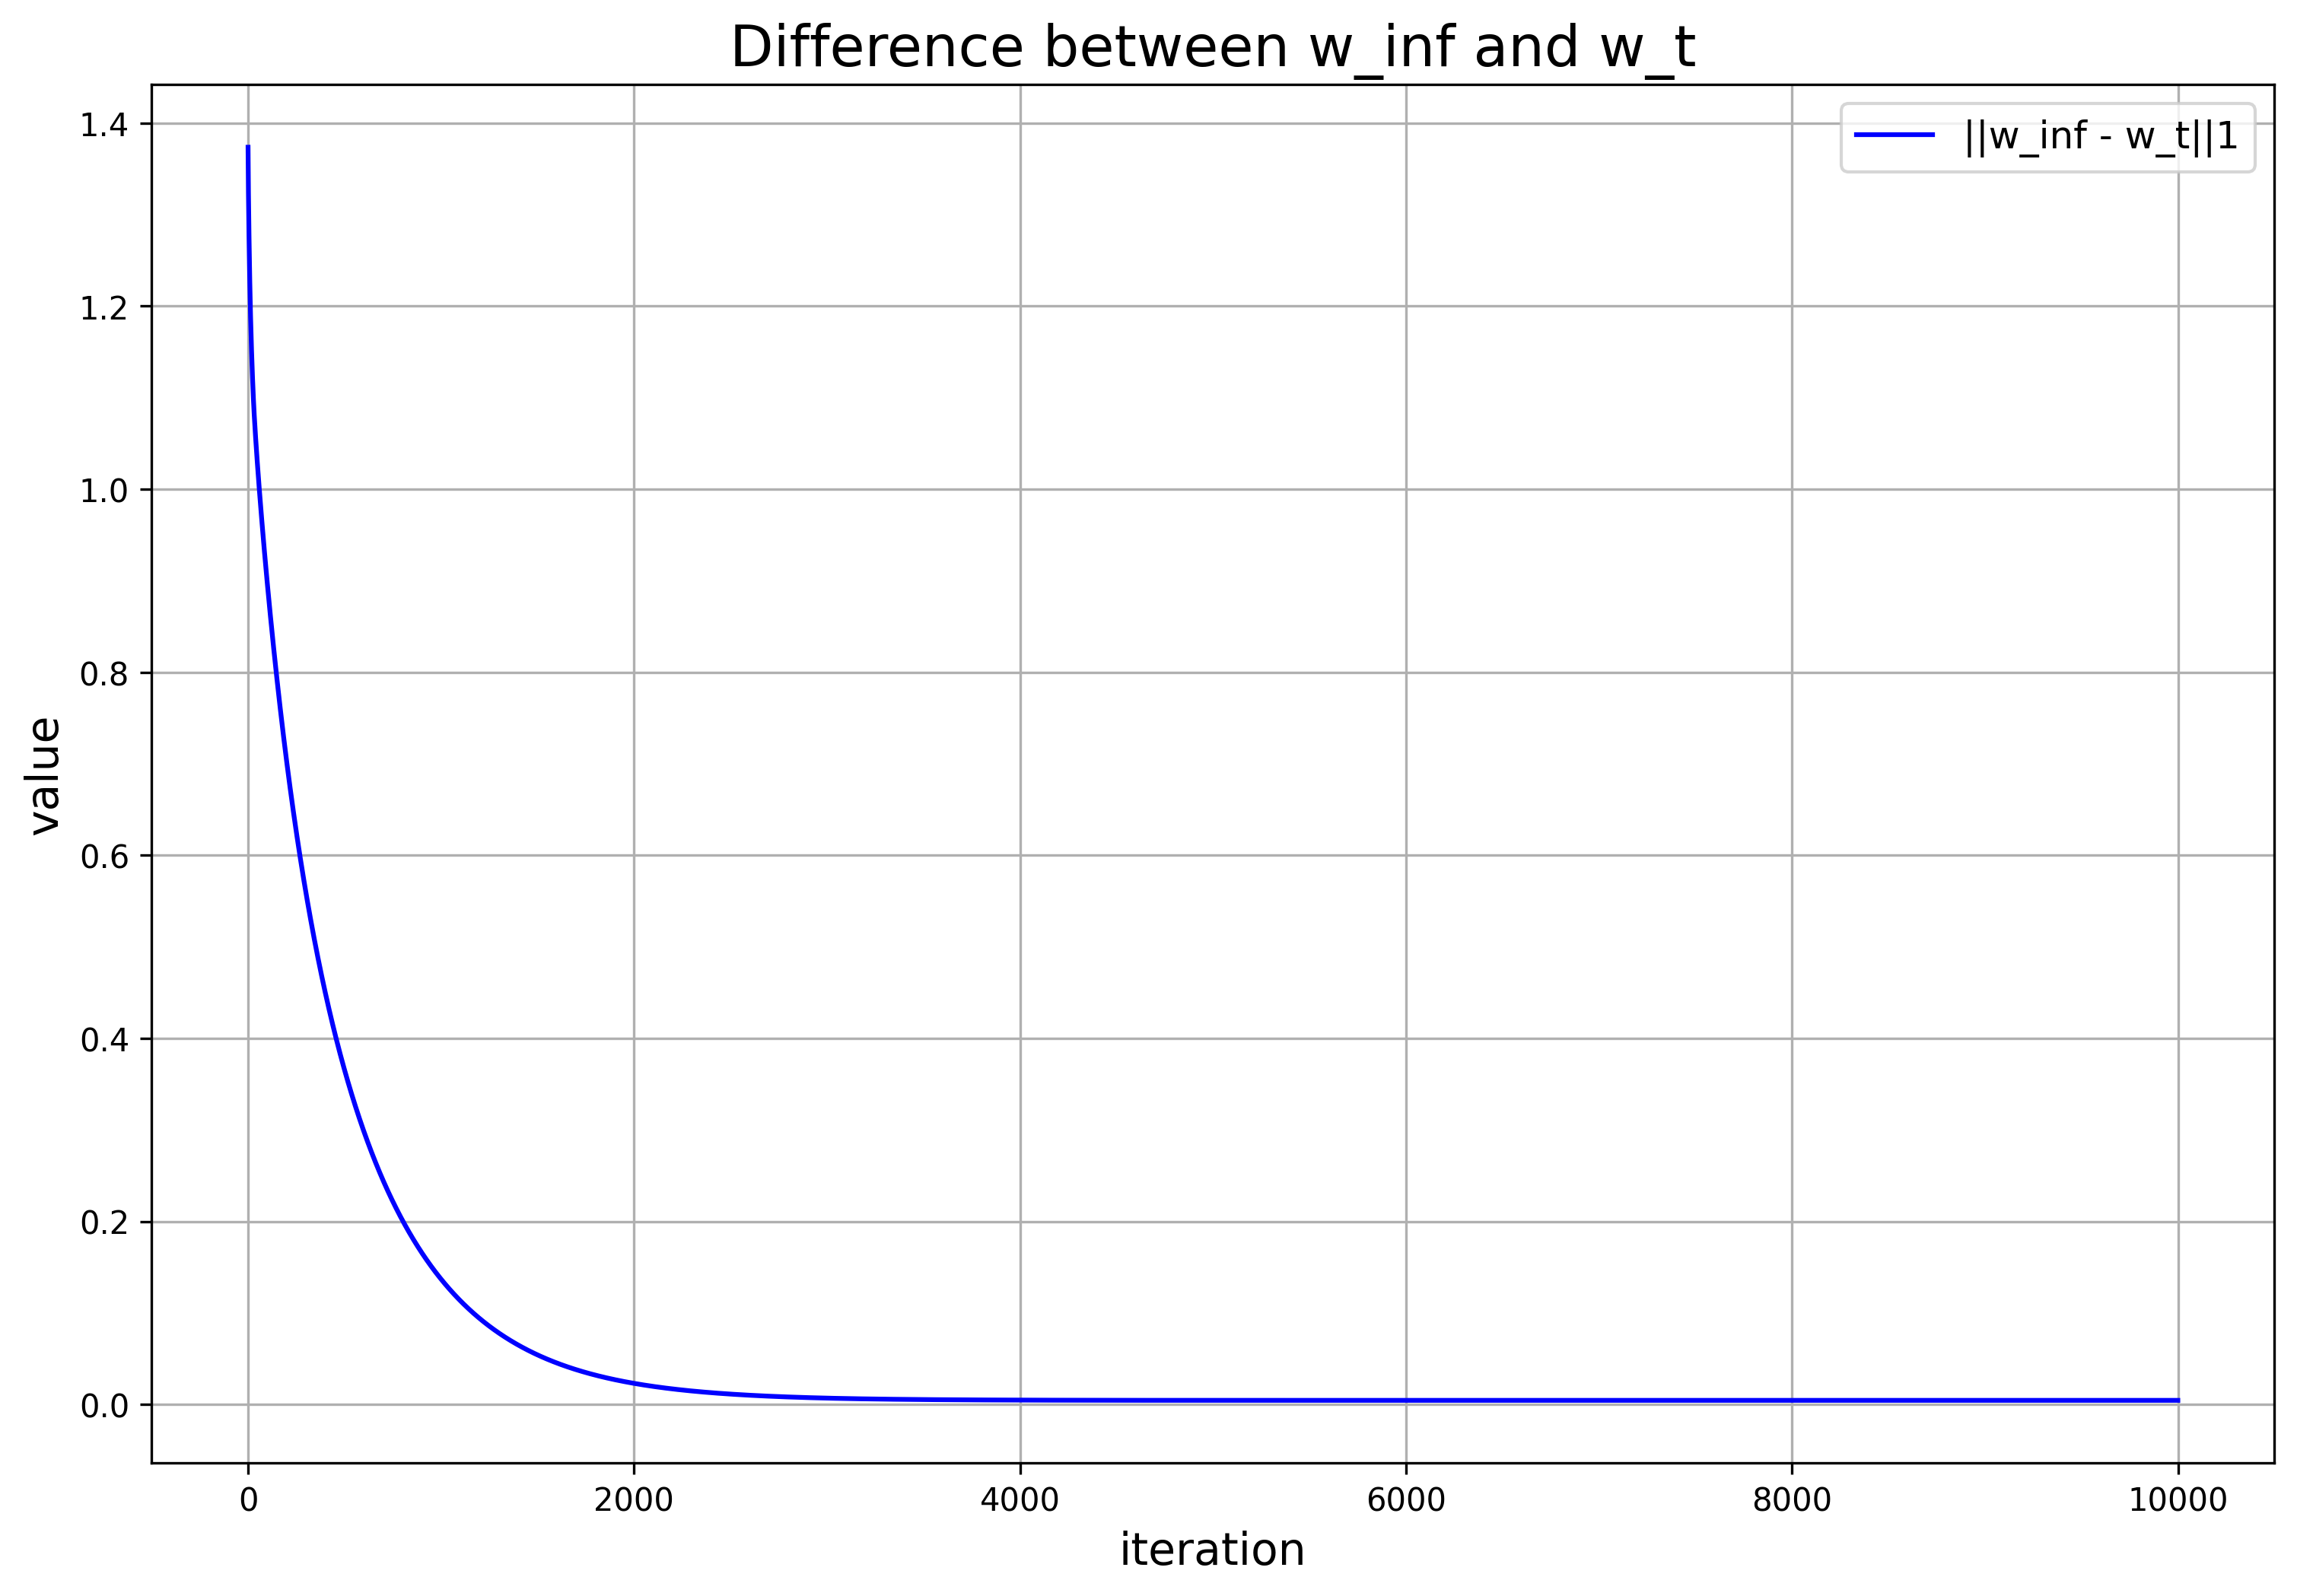

In [16]:
fig = plt.figure(figsize=(12, 8), dpi=300)
plt.plot(diff, label='||w_inf - w_t||1', color='blue')
plt.grid()
plt.legend(fontsize=12)
plt.ylabel('value', fontsize=14)
plt.xlabel('iteration', fontsize=14)
name = 'Difference between w_inf and w_t'
plt.title(name, fontsize=18)
plt.savefig(name + '.png')

# Problem 2

In [167]:
data_path = 'hw4-data/nyt_data.txt'
vocab_path = 'hw4-data/nyt_vocab.dat'
data = pd.read_csv(data_path, sep='\n', header=None)
vocab = pd.read_csv(vocab_path, sep='\n', header=None, names=['words'])

## (a)

In [243]:
N = 3012
M = 8447
X = np.zeros((N, M))
for col in range(M):
    row = data.iloc[col].values[0].split(',')
    for item in row:
        ind, cnt = map(int, item.split(':'))
        X[ind-1][col] = cnt

In [244]:
eps = 1e-16
iteration = 100
K = 25
W = np.random.uniform(1, 2, (N, K))
H = np.random.uniform(1, 2, (K, M))
div_pen = []
for i in range(1, iteration+1):
    if i % 10 == 0:
        print('iteration %d' % i)
    P = X / (W.dot(H)+eps)
    Wt = W.T
    Wt = Wt / Wt.sum(axis=1).reshape(-1, 1)
    H = H * (Wt.dot(P))  # update H
    P = X / (W.dot(H)+eps)
    Ht = H.T
    Ht = Ht / Ht.sum(axis=0).reshape(1, -1)
    W = W * (P.dot(Ht))  # update W
    div_pen.append(np.sum(-X * np.log(W.dot(H)+eps) + W.dot(H)))

iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100


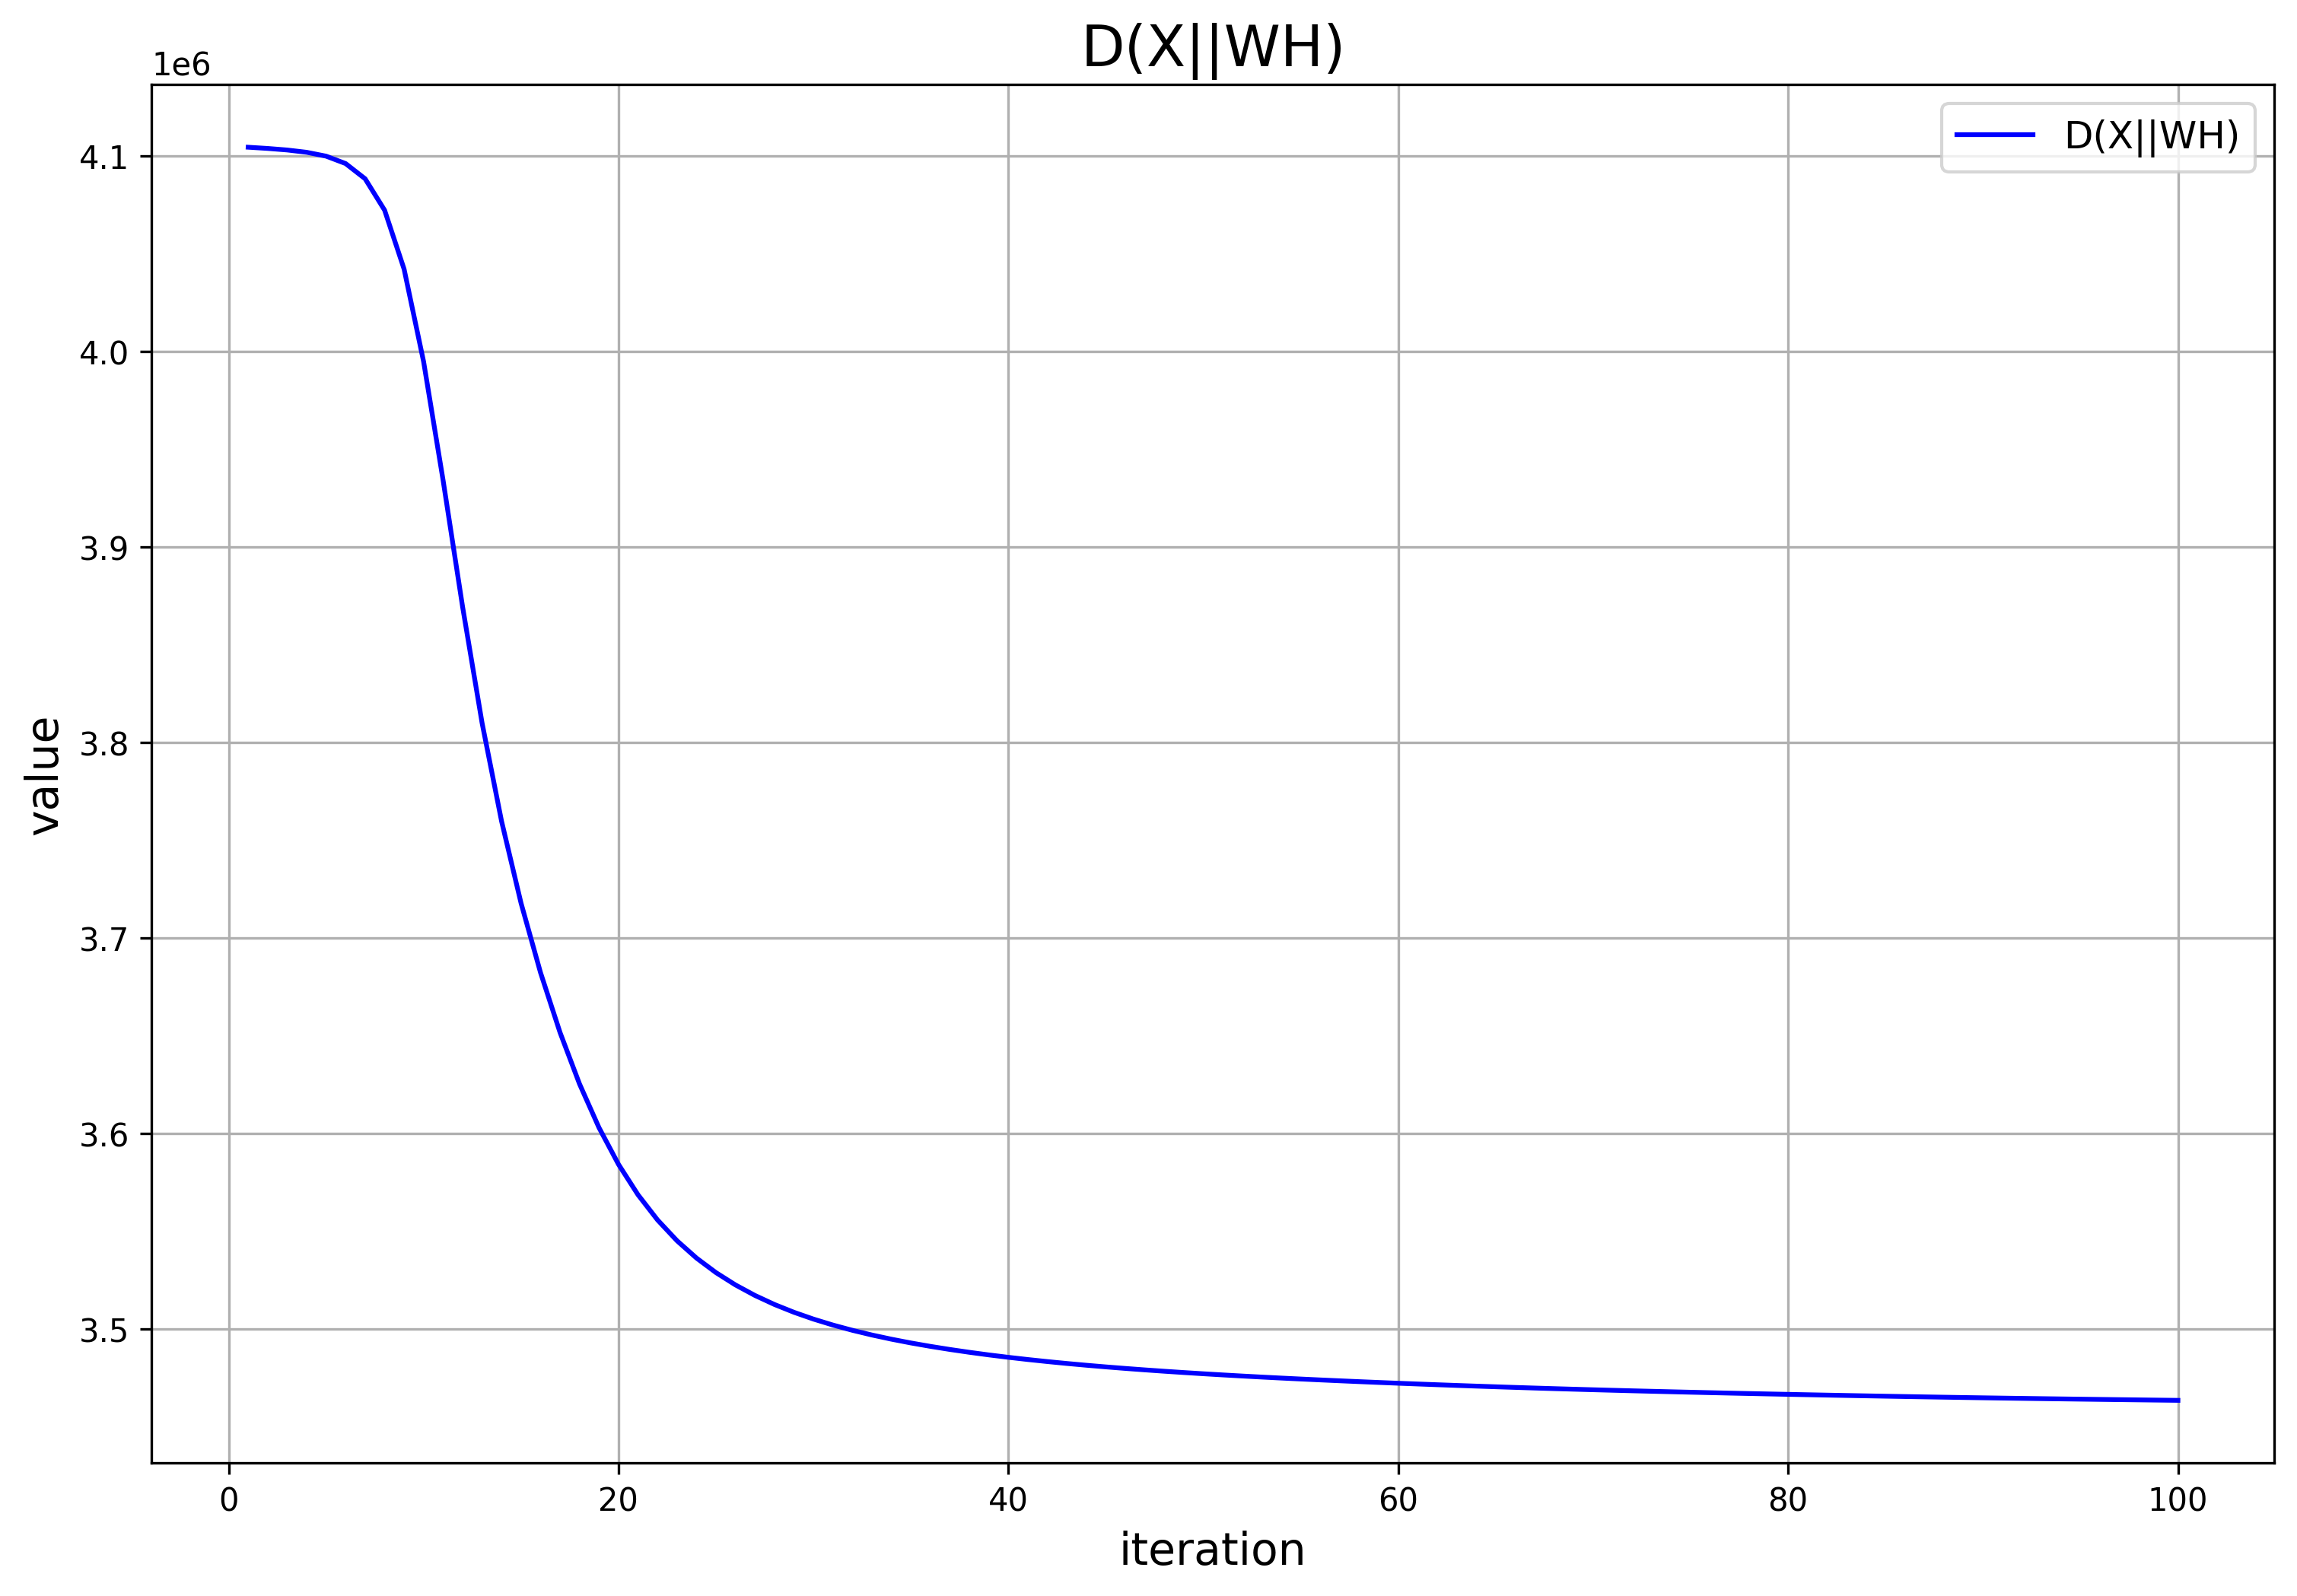

In [245]:
fig = plt.figure(figsize=(12, 8), dpi=300)
plt.plot(np.arange(1, 101), div_pen, label='D(X||WH)', color='blue')
plt.grid()
plt.legend(fontsize=12)
plt.ylabel('value', fontsize=14)
plt.xlabel('iteration', fontsize=14)
name = 'D(X||WH)'
plt.title(name, fontsize=18)
plt.savefig(name + '.png')

## (b)

In [246]:
W = W / W.sum(axis=0).reshape(1,-1)

In [247]:
da = pd.DataFrame(index=range(10), columns=['Topic_%d' % i for i in range(1, 26)])

In [248]:
for i in range(25):
    column = 'Topic_' + str(i+1)
    Wi = W[:, i]
    dt = pd.DataFrame(Wi, columns=['weight'])
    dt['words'] = vocab
    dt = dt.sort_values(by='weight', ascending=False)[:10].reset_index(drop=True)
    da[column] = dt['weight'].map(lambda x: ('%.4f')%x) + ' ' + dt['words']
da.to_excel('topic_words.xlsx', index=False)